# Bcachefs vs. BTRFS

This notebook compares BTRFS to Bcachefs as of commit `4da1205b`.

## Setup

The tests were conducted on Fedora 24 inside a 2GB KVM VM with 2GiB of RAM and access to all cores and features of the host CPU. The disk was an 8TB Western Digital drive taken from a WD My Book external hard drive. Access was done through virtio-blk (virtio-scsi was attempted but failed).

The disk was partitioned into 8 partitions and all tests were conducted on the same partition (after reformatting) to ensure that both filesystems were on the same physical section of the disk.

The BTFS partition was simply formatted with `mkfs.btrfs -f <dev>`.

The bcachefs partition was formatted with `bcache format -b 4096 --bucket=2M --max_journal_entry_size=2M --data_checksum_type=crc32c <dev>` and `journal_write_delay_ms` and `journal_reclaim_delay_ms` were set to 10s in sysfs.

## Benchmark

The `fio` tool was used for all benchmarks. 5 fio benchmarks were defined:
- Sequential read/write, such as would be used for copying files.
- Random read/write as would be used by databases etc.
- A 70/30% mix of read/write as I've heard certain enterprise workloads are mixed.

The configuration is as follows:

```
[global]
ioengine=libaio
size=10g
direct=1
runtime=60
filename=/mnt/bcache/fio.test
per_job_logs=0

[seq-read]
rw=read
bs=1m
write_bw_log=<fs>-seqread_bw.log
write_lat_log=<fs>-seqread_lat.log
write_iops_log=<fs>-seqread_iops.log
per_job_logs=0
stonewall

[rand-read]
bs=4k
rw=randread
write_bw_log=<fs>-randread_bw.log
write_lat_log=<fs>-randread_lat.log
write_iops_log=<fs>-randread_iops.log
per_job_logs=0
stonewall

[seq-write]
rw=write
bs=1m
write_bw_log=<fs>-seqwrite_bw.log
write_lat_log=<fs>-seqwrite_lat.log
write_iops_log=<fs>-seqwrite_iops.log
per_job_logs=0
stonewall

[rand-write]
bs=4k
rw=randwrite
write_bw_log=<fs>-randwrite_bw.log
write_lat_log=<fs>-randwrite_lat.log
write_iops_log=<fs>-randwrite_iops.log
per_job_logs=0
stonewall

[8k7030]
bs=8k
rw=randrw
rwmixread=70
iodepth=16
numjobs=16
write_bw_log=<fs>-70mix_bw.log
write_lat_log=<fs>-70mix_lat.log
write_iops_log=<fs>-70mix_iops.log
per_job_logs=0
stonewall
```

In [202]:
# Imports
%matplotlib inline

import csv, pandas as pd, itertools, os
import matplotlib, matplotlib.pyplot as plt, matplotlib.colors

In [199]:
filesystems = ['btrfs', 'bcachefs']
tests = ['seqread', 'seqwrite', 'randread', 'randwrite', '70mix-read', '70mix-write']
metrics = ['bw.bw', 'iops.iops', 'lat.clat', 'lat.lat', 'lat.slat']
filename_format = '{fs}-{test}_{metric1}.log_{metric2}.log'
test_directory = '/data/Scratch/dump/vmfio'

In [196]:
def get_set(test, metric):
    metric1, metric2 = tuple(metric.split('.'))
    direction = None
    if '-' in test:
        test, direction = tuple(test.split('-'))
        direction = 0 if direction == 'read' else 1
    btrfs_filename = os.path.join(test_directory, filename_format.format(fs='btrfs', test=test, metric1=metric1, metric2=metric2))
    bcache_filename = os.path.join(test_directory, filename_format.format(fs='bcachefs', test=test, metric1=metric1, metric2=metric2))
    btrfs_ds = pd.read_csv(btrfs_filename, index_col=0, names=['time', metric2, 'direction', 'blocksize'])
    bcache_ds = pd.read_csv(bcache_filename, index_col=0, names=['time', metric2, 'direction', 'blocksize'])
    if direction is not None:
        btrfs_ds = btrfs_ds[btrfs_ds.direction == direction].copy()
        bcache_ds = bcache_ds[bcache_ds.direction == direction].copy()
    return btrfs_ds, bcache_ds

In [207]:
def plot(btds, bcds, metric='bw', unit='KB/s', title=None):
    if metric.endswith('lat'):
        plt.figure('bcache', figsize=(18,8))
        if title:
            plt.title('bcache ' + title)
        std = bcds.lat.std()
        avg = bcds.lat.mean()
        valmax = avg + 1.5*std
        ps = bcds.lat[bcds.lat < valmax]
        plt.hist2d(ps.index/1000, ps, bins=80)
        plt.plot((0, 60), (avg, avg), color='orange', linewidth=5.0)
        plt.plot((0, 60), (avg+std, avg+std), color='orange', linewidth=2.0)
        plt.colorbar()
        plt.figtext(0, 0.05, "bcachefs mean: {:.3f} {unit}, stddev: {:.3f} {unit}".format(btds[metric].mean(), btds[metric].std(), unit=unit))

        plt.figure('btrfs', figsize=(18,8))
        if title:
            plt.title('btrfs ' + title)
        std = btds.lat.std()
        avg = btds.lat.mean()
        valmax = avg + 2*std
        ps = btds.lat[btds.lat < valmax]
        plt.hist2d(ps.index/1000, ps, bins=80)
        plt.plot((0, 60), (avg, avg), color='orange', linewidth=5.0)
        plt.plot((0, 60), (avg+std, avg+std), color='orange', linewidth=2.0)
        plt.colorbar()
        plt.figtext(0, 0.05, "BTRFS: mean: {:.3f} {unit}, stddev: {:.3f} {unit}".format(bcds[metric].mean(), bcds[metric].std(), unit=unit))
        plt.show()
    else:
        plt.figure(figsize=(12, 8), dpi=100)
        plt.gca().set_position((0, 0, 1.0, 0.6))
        
        if title:
            plt.title(title)
        
        pointsize = 3.0 if len(btds[metric]) < 1000 else 0.2

        avg = btds[metric].mean()
        stddevx2 = btds[metric].std()
        plt.scatter(btds.index, btds[metric], c='blue', edgecolors='blue', s=pointsize)
        plt.plot((btds.index.min(), btds.index.max()), (avg, avg), color='darkblue', linewidth=3.0)
        plt.plot((btds.index.min(), btds.index.max()), (avg + stddevx2, avg + stddevx2), color='darkblue', linewidth=3.0)
        plt.plot((btds.index.min(), btds.index.max()), (avg - stddevx2, avg - stddevx2), color='darkblue', linewidth=3.0)


        avg = bcds[metric].mean()
        stddevx2 = bcds[metric].std()
        plt.scatter(bcds.index, bcds[metric], c='red', edgecolors='red', s=pointsize)
        plt.plot((bcds.index.min(), bcds.index.max()), (avg, avg), color='darkred', linewidth=3.0)
        plt.plot((bcds.index.min(), bcds.index.max()), (avg + stddevx2, avg + stddevx2), color='darkred', linewidth=3.0)
        plt.plot((bcds.index.min(), bcds.index.max()), (avg - stddevx2, avg - stddevx2), color='darkred', linewidth=3.0)

        plt.xlim(bcds.index.min(), bcds.index.max())
        plt.ylim(0, max(bcds[metric].quantile(0.99), btds[metric].quantile(0.99)))
    
        plt.figtext(0, -0.1, "BTRFS mean: {:.3f} {unit}, stddev: {:.3f} {unit}".format(btds[metric].mean(), btds[metric].std(), unit=unit) + "\n" + "bcachefs: mean: {:.3f} {unit}, stddev: {:.3f} {unit}".format(bcds[metric].mean(), bcds[metric].std(), unit=unit))
    plt.show()

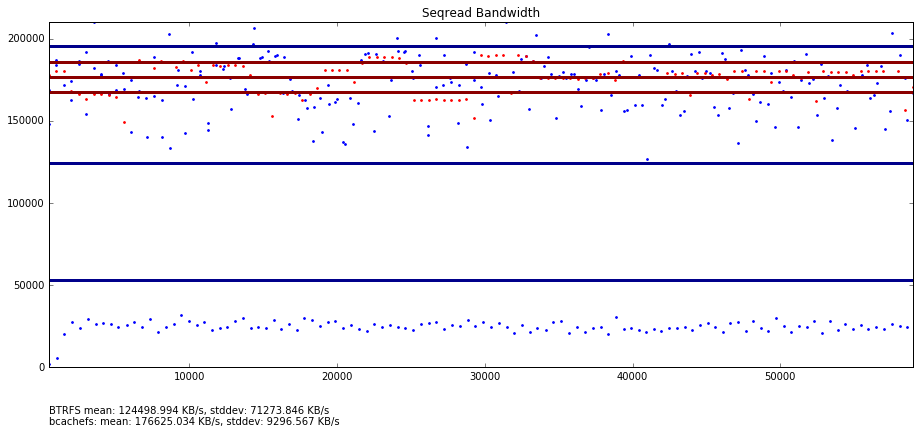

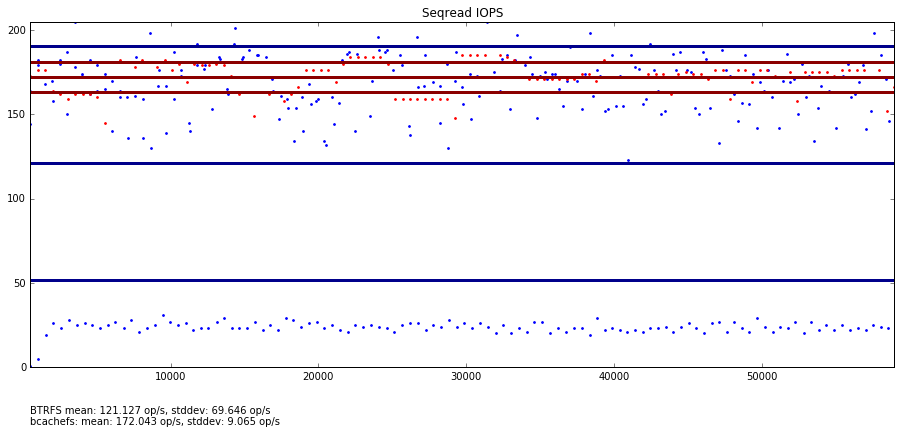

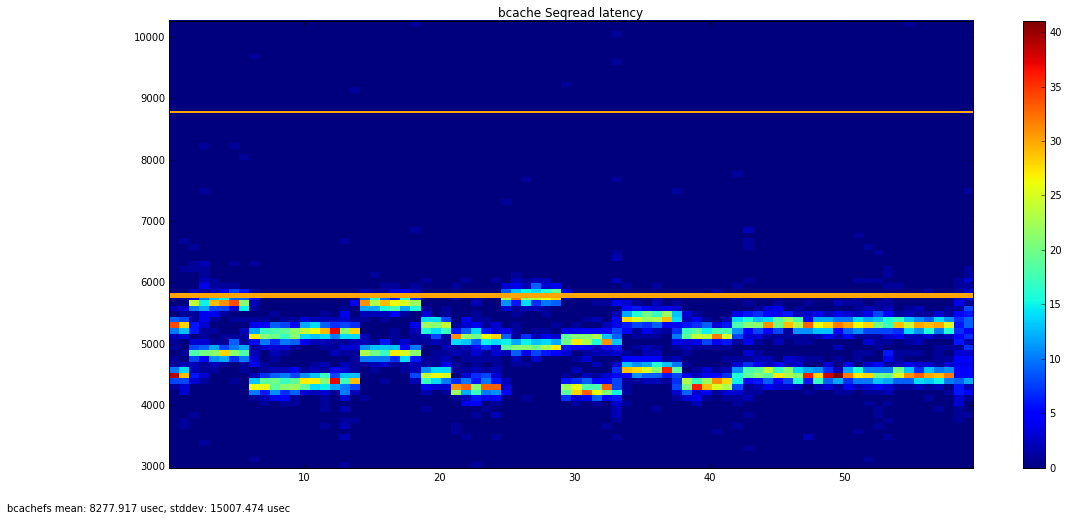

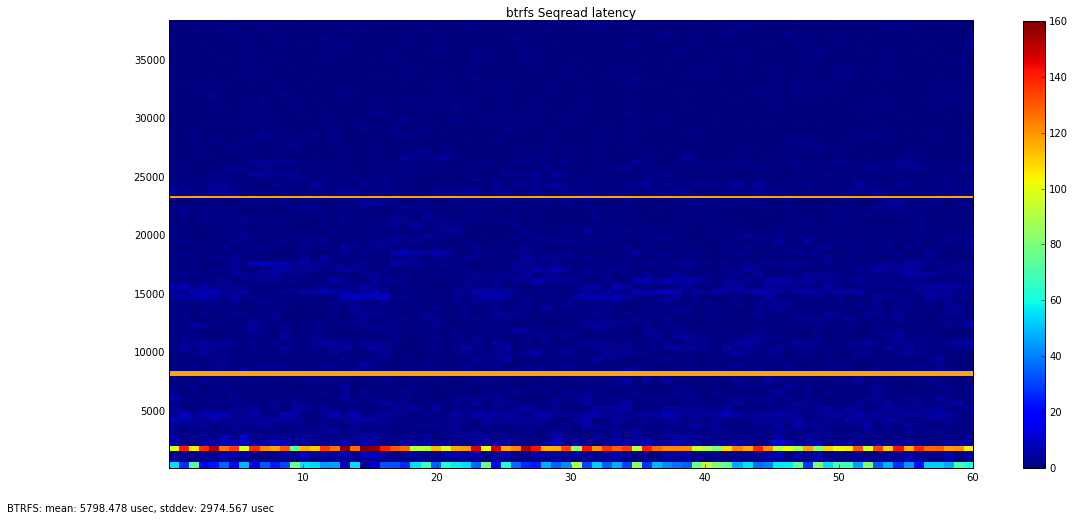

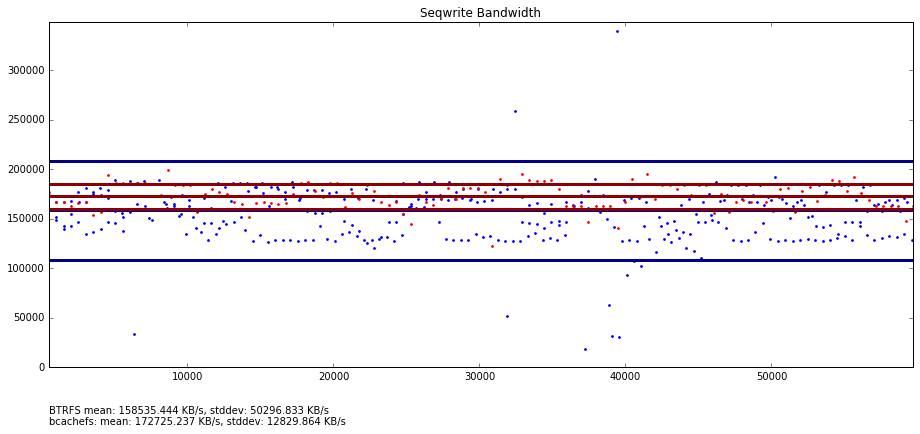

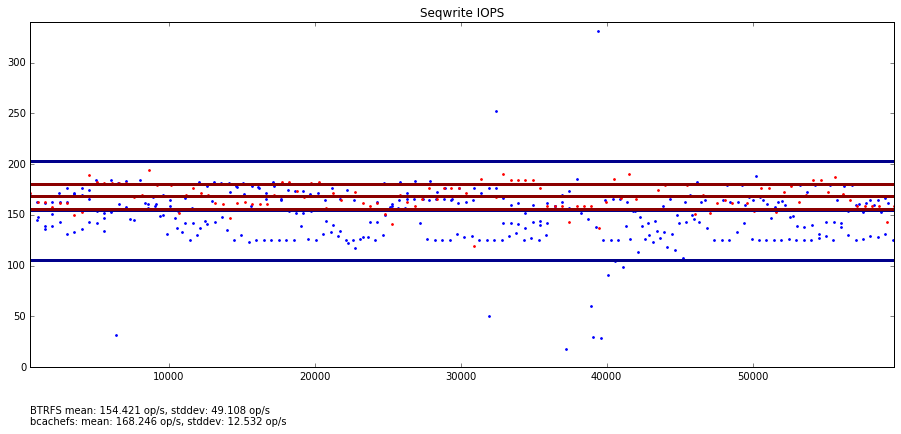

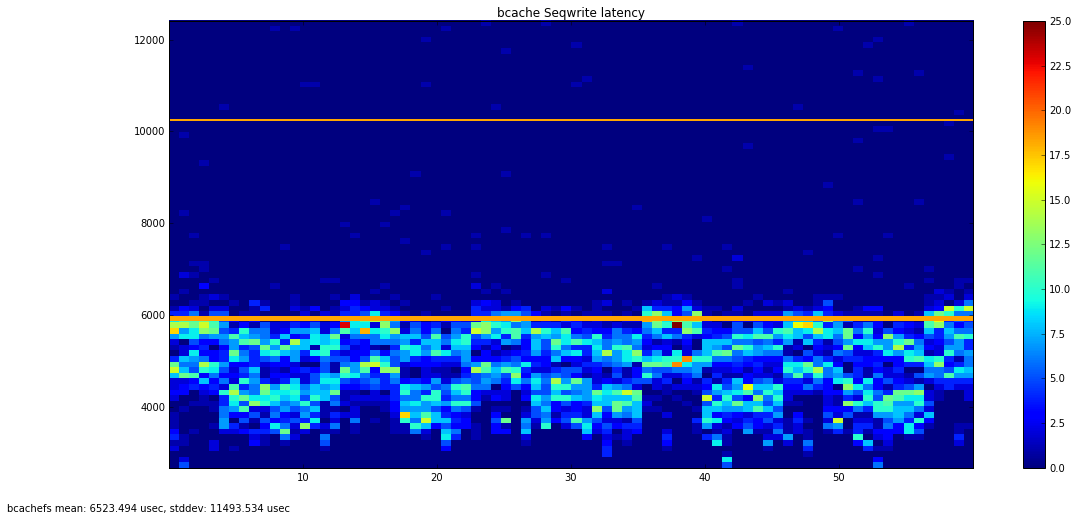

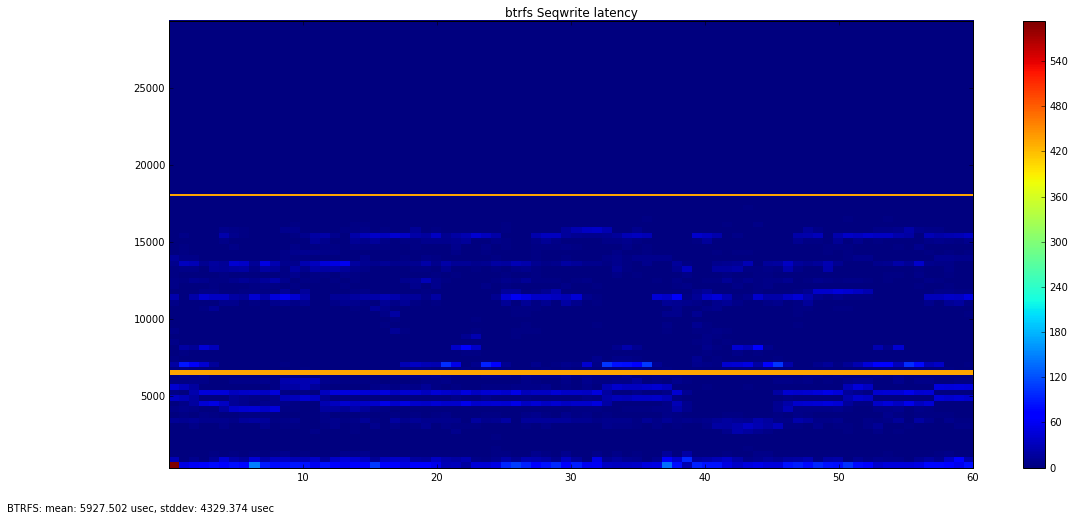

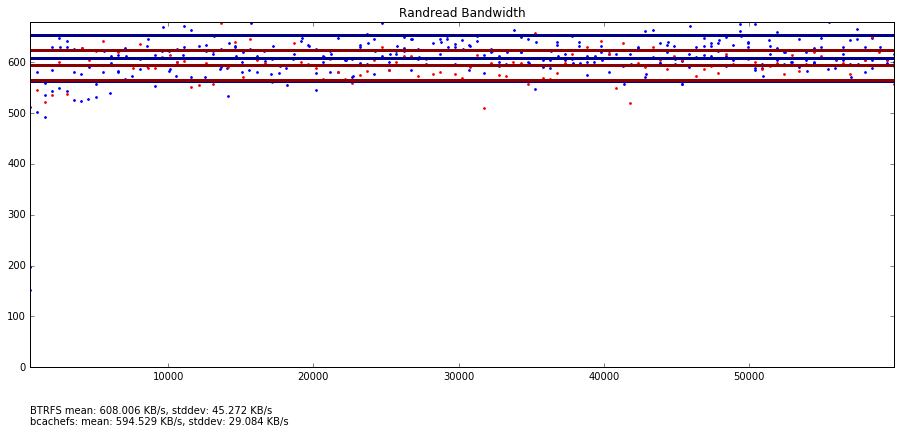

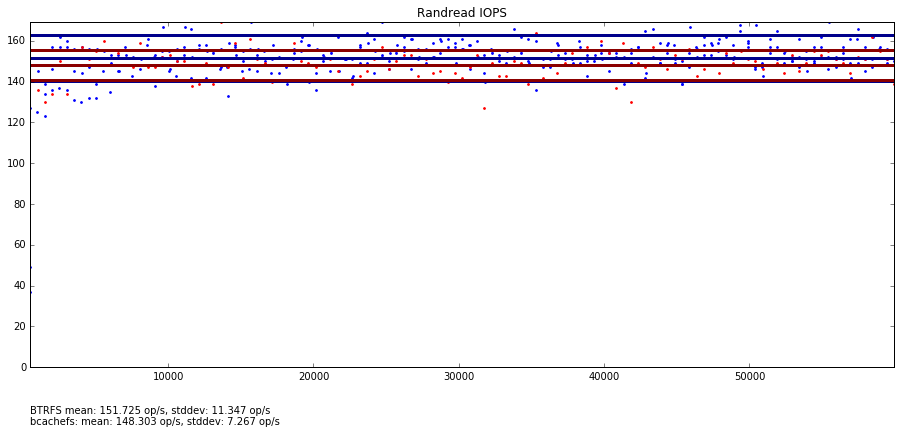

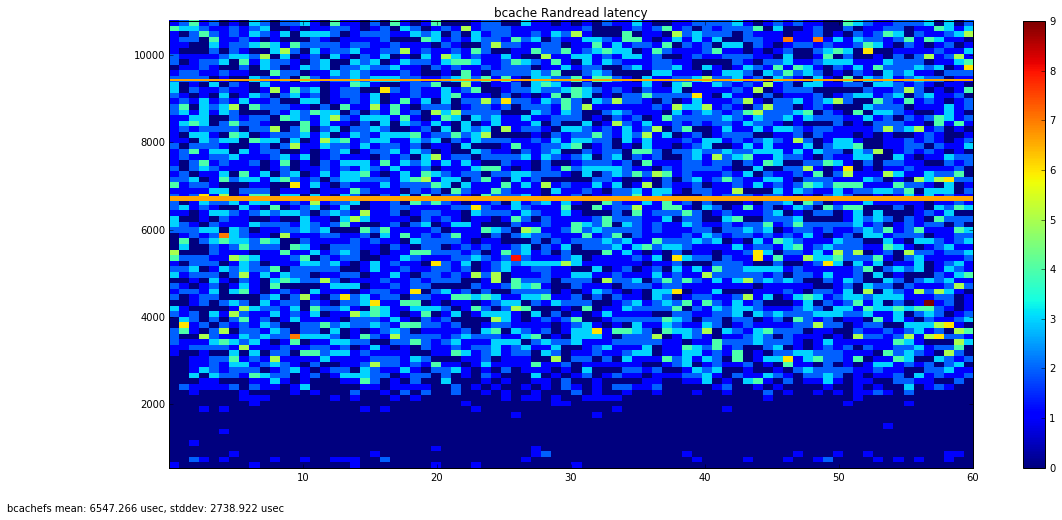

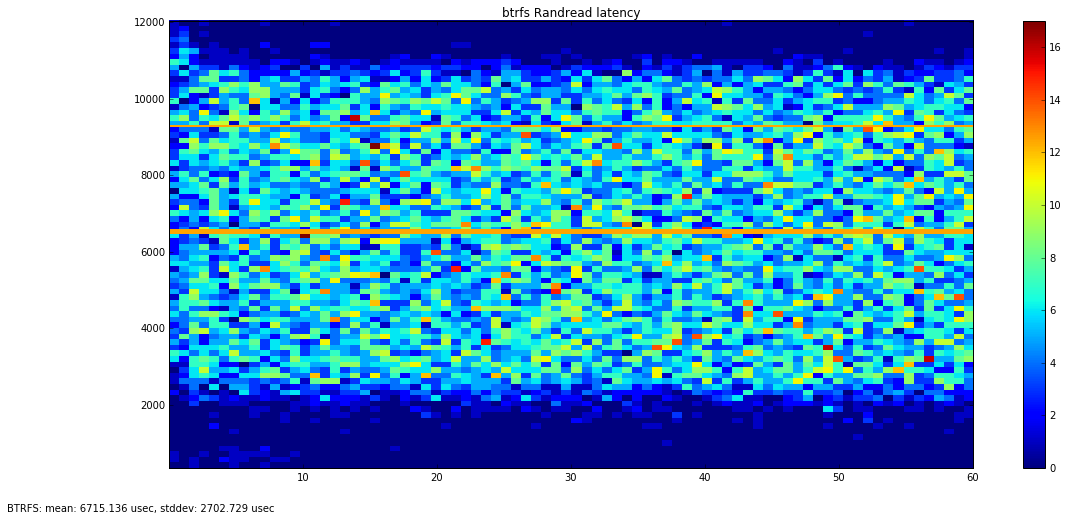

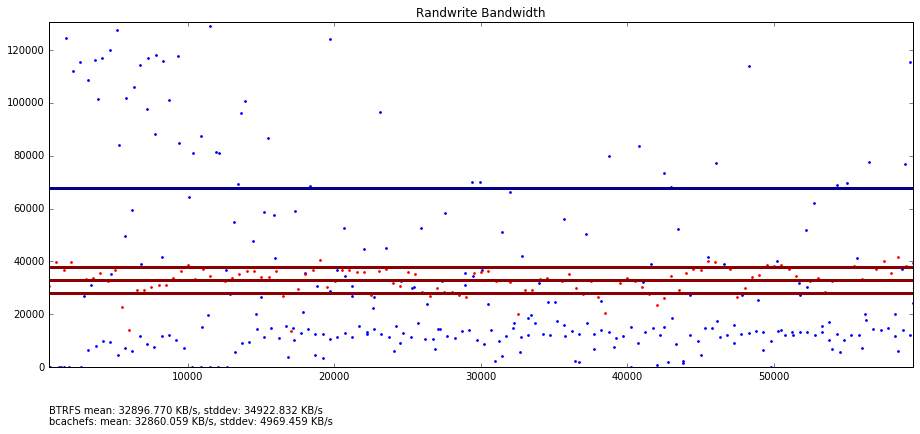

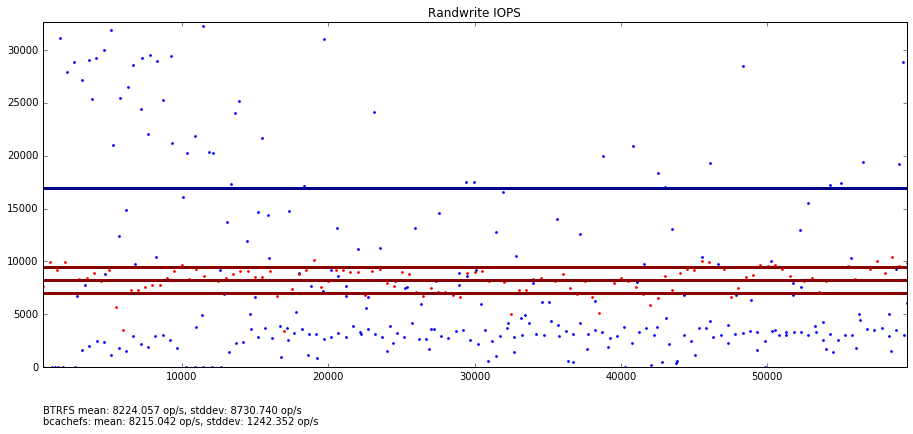

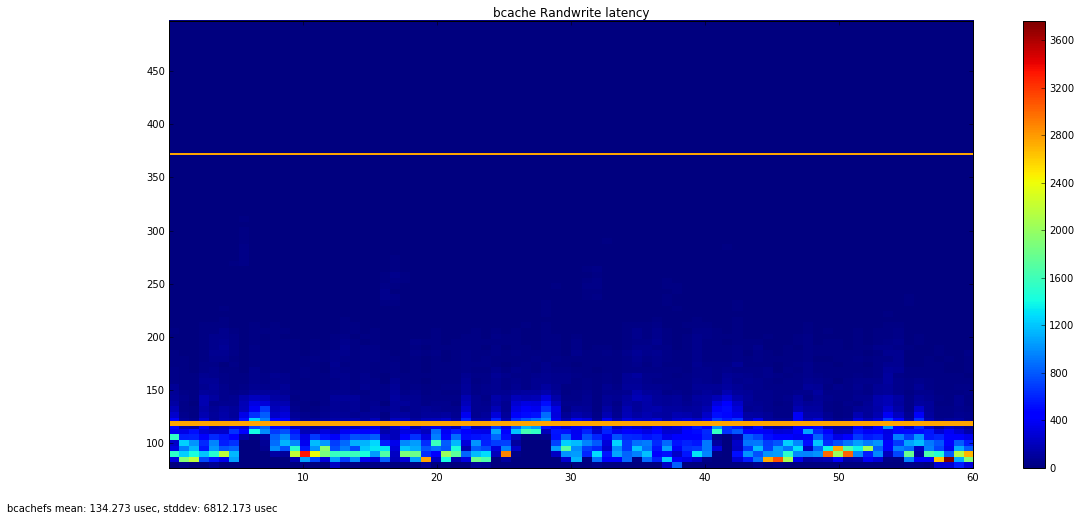

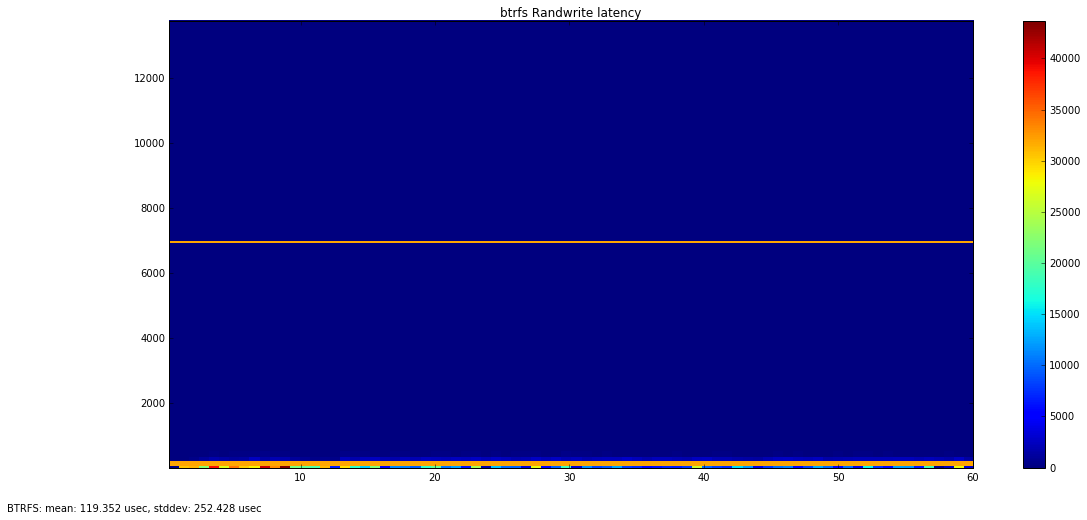

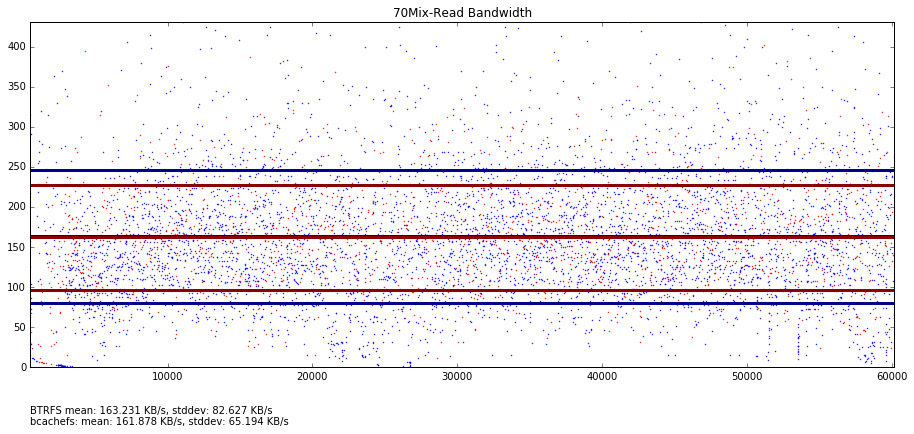

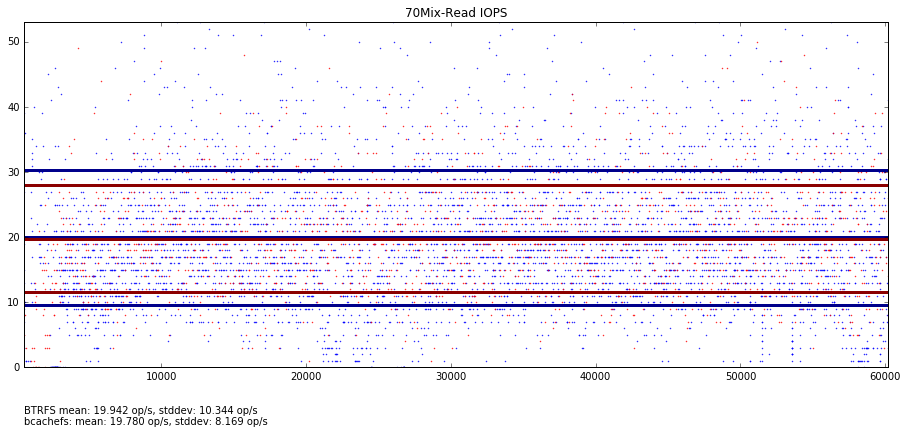

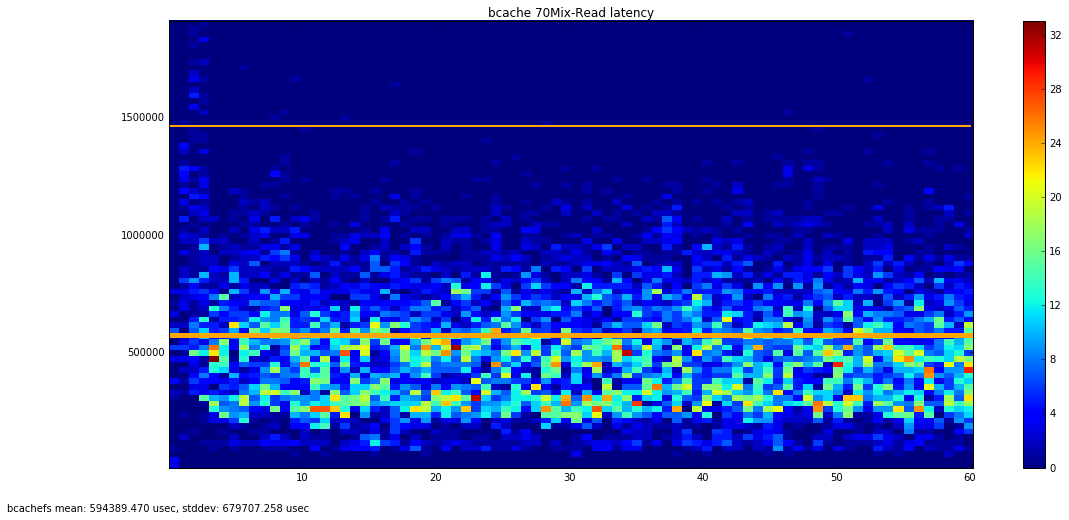

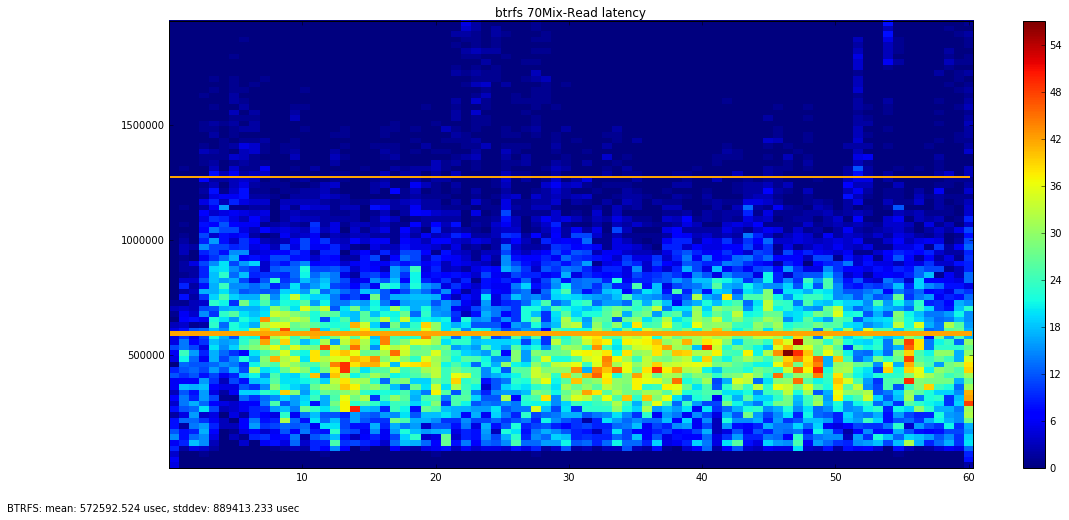

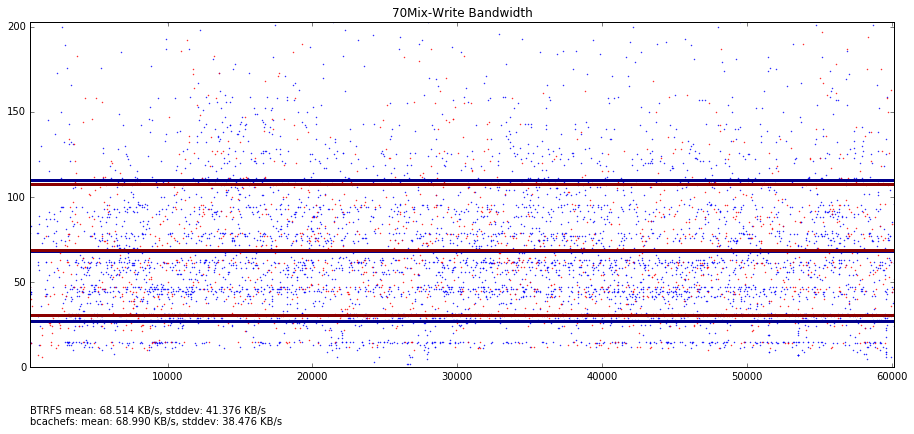

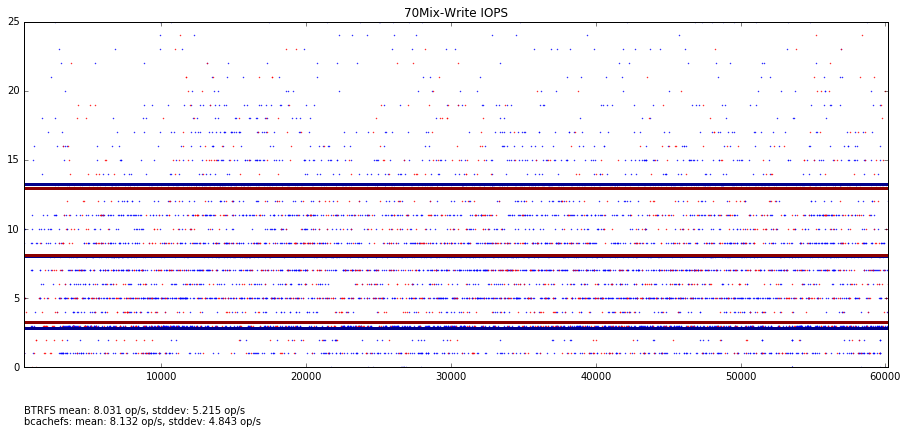

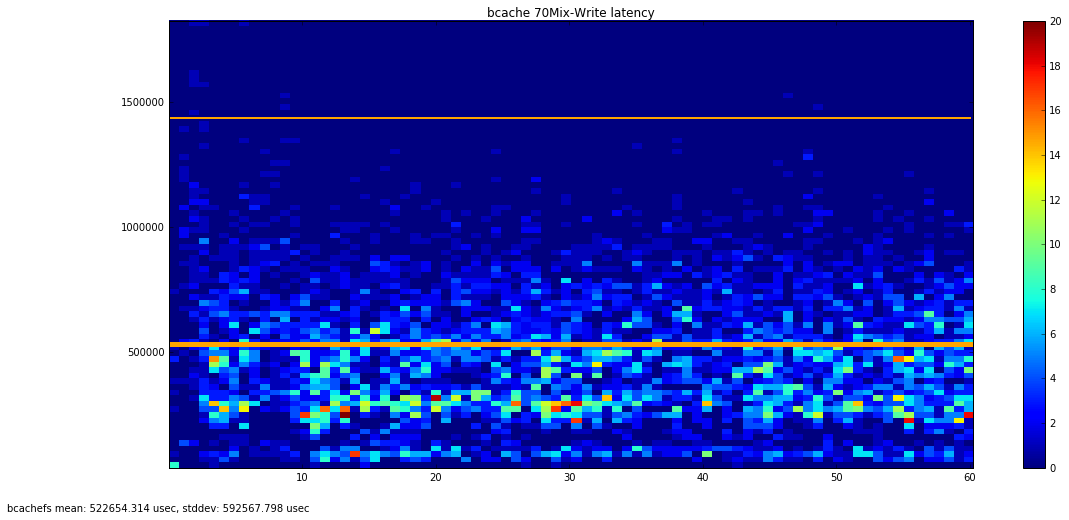

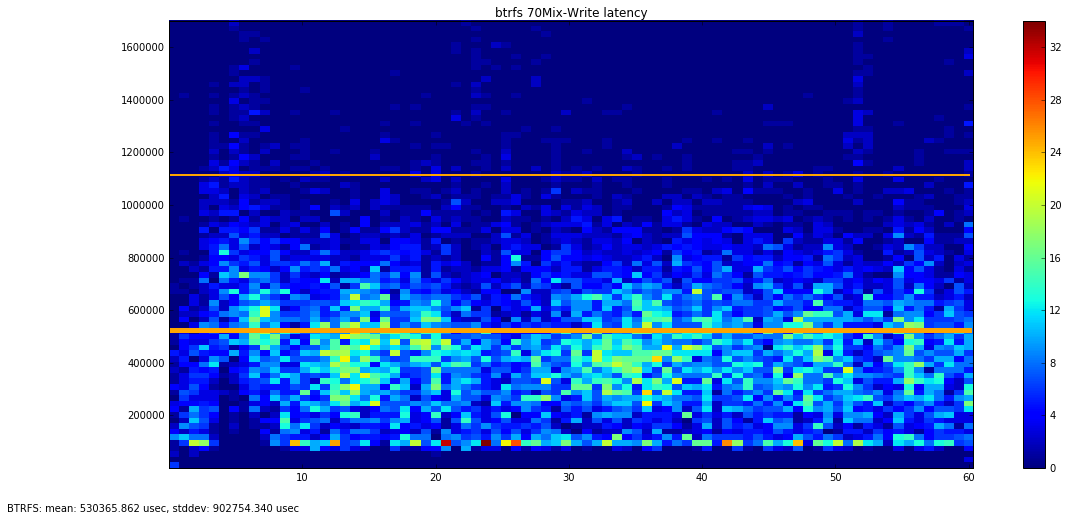

In [208]:
for test in tests:
    plot(*get_set(test, 'bw.bw'), metric='bw', unit='KB/s', title=test.title() + ' Bandwidth')
    plot(*get_set(test, 'iops.iops'), metric='iops', unit='op/s', title=test.title() + ' IOPS')
    plot(*get_set(test, 'lat.lat'), metric='lat', unit='usec', title=test.title() + ' latency')